#Introduction
Welcome to my time series forecasting kernel, focused on predicting electricity demand using historical data from the Africa National Grid. In this project, I will systematically approach the task by following the next steps:

    Performing EDA and Feature Engineering: The first stage involves exploratory data analysis (EDA) to better understand the dataset, clean it, and create new features that can enhance our predictive models. This phase will also help us uncover any underlying trends and seasonality in the electricity demand data.

    Utilizing SARIMA Models: In this phase, I will employ Seasonal Autoregressive Integrated Moving Average (SARIMA) models to predict electricity demand. To build an effective SARIMA model, we will need to examine the data's variations and conduct additional EDA to estimate the model parameters accurately.


In [ ]:
!pip install -q  pmdarima
!pip install -q workalendar
!pip install -q prophet
!pip install -q --upgrade linear-tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


IMPORTING REQUIRED LIBRARIES¶


In [ ]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging
import warnings

import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.africa import kenya
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset/electricity_demand.csv", index_col=0)
# Changing column names to lower case
df.columns = df.columns.str.lower()
df.shape

(154502, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154502 entries, 0 to 257420
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   settlement_date            154502 non-null  object 
 1   settlement_period          154502 non-null  int64  
 2   nd                         154502 non-null  int64  
 3   tsd                        154502 non-null  int64  
 4   demand                     154502 non-null  int64  
 5   embedded_wind_generation   154502 non-null  int64  
 6   embedded_wind_capacity     154502 non-null  int64  
 7   embedded_solar_generation  154502 non-null  int64  
 8   embedded_solar_capacity    154502 non-null  int64  
 9   non_bm_stor                154502 non-null  int64  
 10  pump_storage_pumping       154502 non-null  int64  
 11  ifa_flow                   154502 non-null  int64  
 12  ifa2_flow                  154502 non-null  int64  
 13  britned_flow               15

In [ ]:
#df=df.loc['2018-01-01':]
#df.shape

In [ ]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)
df.head()

,settlement_date,settlement_period,nd,tsd,demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday,country,town,kenyan_bank_holiday
0,01-01-09,1,37910,38704,33939,54,1403,0,0,0,...,0,-161,0,0,NaN,NaN,1,Kenya,Thika,1
1,01-01-09,2,38047,38964,34072,53,1403,0,0,0,...,0,-160,0,0,NaN,NaN,1,Kenya,Nakuru,1
2,01-01-09,3,37380,38651,33615,53,1403,0,0,0,...,0,-160,0,0,NaN,NaN,1,Kenya,Thika,1
3,01-01-09,4,36426,37775,32526,50,1403,0,0,0,...,0,-160,0,0,NaN,NaN,1,Kenya,Eldoret,1
4,01-01-09,6,35408,37135,31604,43,1403,0,0,0,...,0,-160,0,0,NaN,NaN,1,Kenya,Nakuru,1


###DATA PREPROCESSING
Two columns include nan values. Let's check how many nan values there are in each column

In [ ]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

,nsl_flow,eleclink_flow
True,105271,105271
False,49231,49231


Droping those two features where the settlement_period exceeds 48, as values beyond 48 indicate data logging errors.

In [ ]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

In [ ]:
# Calculate the mean of 'tsd' column excluding 0 values
mean_tsd = df[df['tsd'] != 0]['tsd'].mean()

# Fill 0 values in 'tsd' column with the mean
df.loc[df['tsd'] == 0, 'tsd'] = mean_tsd

creating a histogram that will show outliers which are equal to zero

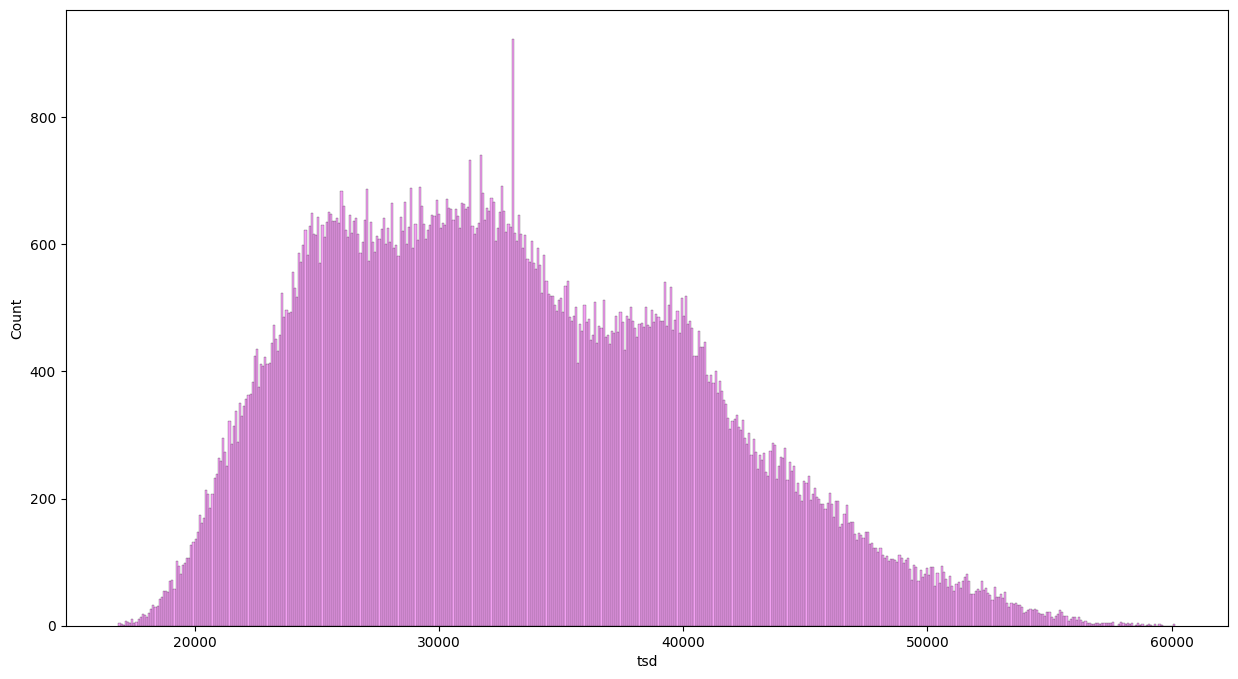

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="violet");

In [ ]:
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(5)

,settlement_date,settlement_period,period_hour,nd,tsd,demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday,country,town,kenyan_bank_holiday
49902,10-10-14,6,2:30:00,24032,26308.0,21840,882,3679,0,5441,...,1245,0,1014,-174,-91,0,0,Kenya,Mombasa,0
67403,14-03-22,31,15:00:00,30073,32087.0,27418,2277,6545,3989,13744,...,-1,-1028,0,-237,0,-143,0,Kenya,Mombasa,0
71867,15-02-17,12,5:30:00,29144,31287.0,26351,888,4781,0,11503,...,-302,0,1016,297,287,0,0,Kenya,Mombasa,0
79346,16-08-11,6,2:30:00,23414,25673.0,21138,375,1828,0,545,...,997,0,319,-35,0,0,0,Kenya,Nakuru,0
40142,08-11-15,21,10:00:00,31552,32170.0,29068,2482,4013,546,8985,...,1497,0,1026,193,285,0,0,Kenya,Eldoret,0


In [ ]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday,country,town,kenyan_bank_holiday
42106,2010-09-04 01:30:00,4,1:30:00,29213,31707.0,26294,129,1883,0,18,...,-411,0,0,-276,0,0,0,Kenya,Thika,0
133094,2020-03-27 05:30:00,12,5:30:00,23072,23779.0,20950,850,6559,3,13080,...,1503,0,716,-97,0,844,0,Kenya,Nairobi,0
151139,2009-12-30 00:30:00,2,0:30:00,33879,35822.0,30123,1233,1773,0,0,...,1992,0,0,-127,0,0,0,Kenya,Nairobi,0
67510,2010-04-14 22:00:00,45,22:00:00,36928,38978.0,33421,586,1883,0,19,...,-1144,0,0,-391,0,0,0,Kenya,Nairobi,0
118397,2017-04-24 18:00:00,37,18:00:00,35002,35443.0,32080,3138,5108,1290,11750,...,1996,0,992,238,0,0,0,Kenya,Mombasa,0


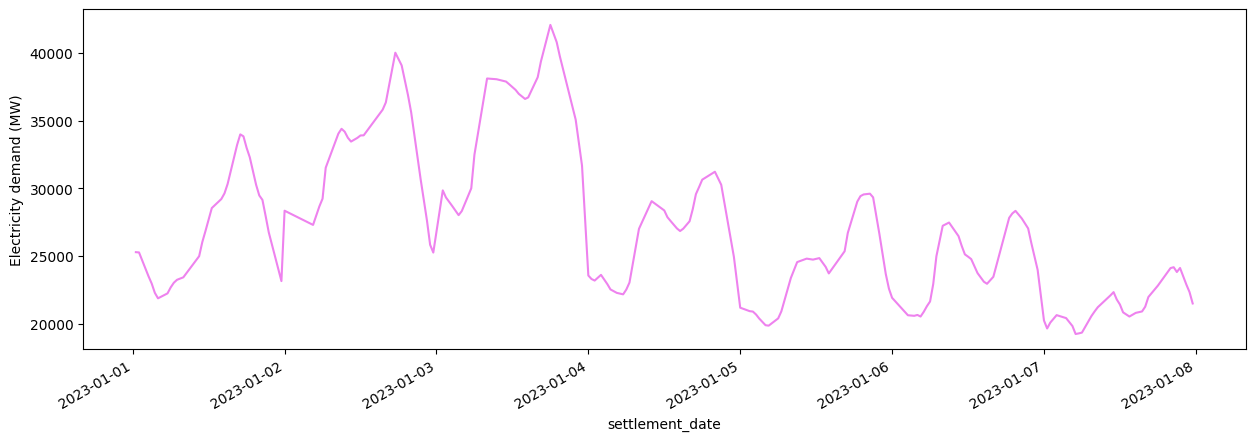

In [ ]:
#The `settlement_date` column is now in the right format to use an index:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2023") & (df.index < "01-08-2023")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)", color = 'violet'
)
ax.legend();

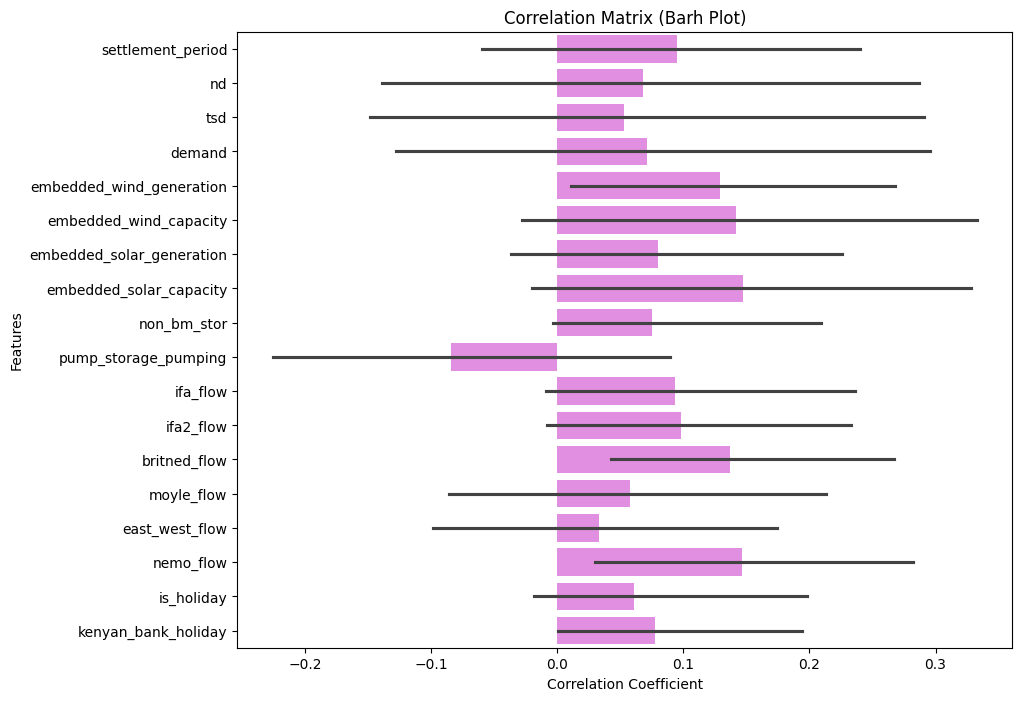

In [ ]:

corr_matrix = df.corr()

# Reshape correlation matrix into long format
corr_long = pd.melt(corr_matrix.reset_index(), id_vars='index')

# Plotting the correlation matrix as a barh plot
plt.figure(figsize=(10, 8))
sns.barplot(x='value', y='index', data=corr_long, orient='h',color='violet')
plt.title('Correlation Matrix (Barh Plot)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

## Feature Engineering

Creating features based on time series index

In [ ]:
def create_features(df):
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df
#Adding three lags to the dataset containing information from the previous 3 years.
def add_lags(df):
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [ ]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

,settlement_period,period_hour,nd,tsd,demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2020-03-29 10:30:00,22,10:30:00,22915,23905.0,20640,3665,6559,5980,13080,0,...,29,6,89,1,3,2020,13,28238.0,NaN,36277.0
2010-04-02 22:00:00,45,22:00:00,39297,41732.0,35371,1412,1824,0,0,0,...,2,4,92,2,4,2010,13,NaN,NaN,NaN
2019-08-29 02:30:00,6,2:30:00,19976,21328.0,18368,1223,6182,0,13080,0,...,29,3,241,3,8,2019,35,22625.0,NaN,29436.0
2014-10-07 07:30:00,16,7:30:00,32630,33142.0,29798,582,3344,761,4982,0,...,7,1,280,4,10,2014,41,26928.0,NaN,43668.0
2013-05-02 23:00:00,47,23:00:00,33652,35515.0,30480,1470,2085,0,2169,0,...,2,3,122,2,5,2013,18,NaN,NaN,29440.0


##EDA

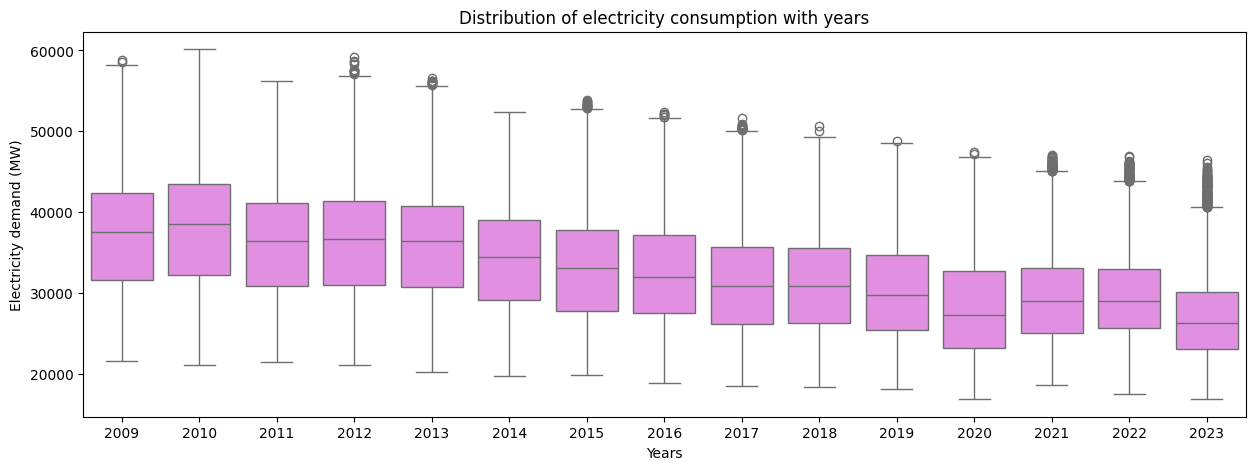

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df, color = 'violet')

ax.set_xlabel("Years")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

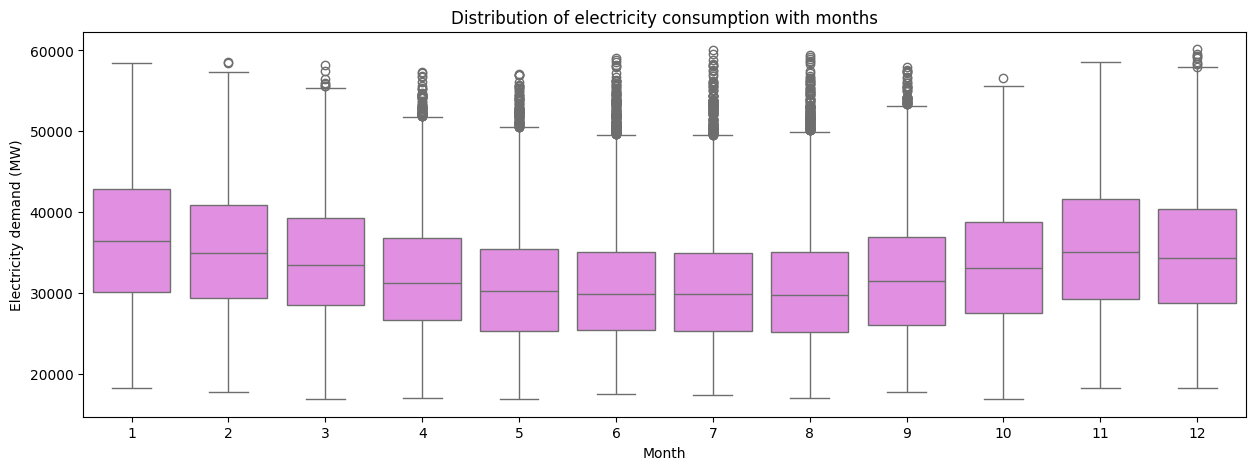

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df, color = 'violet')

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

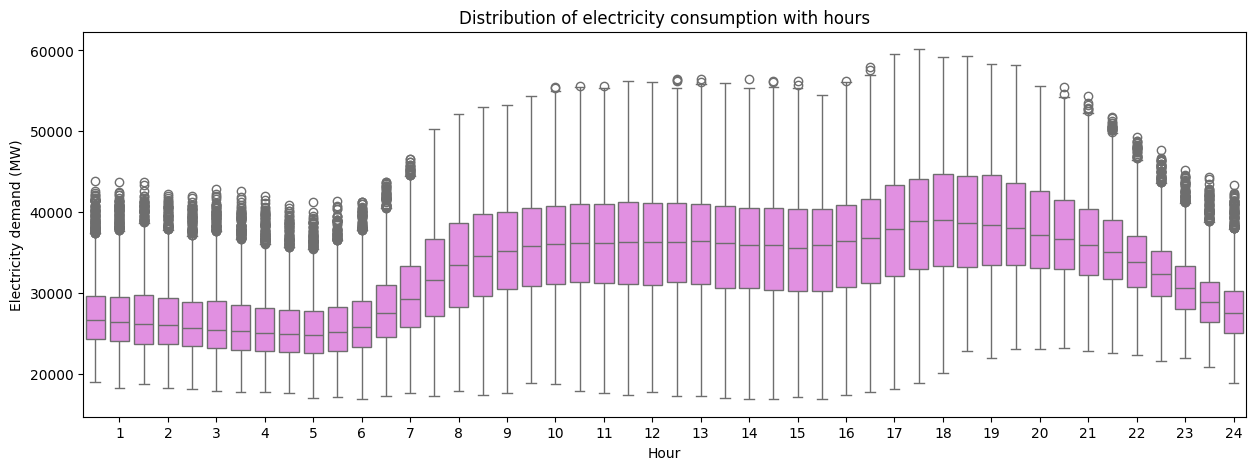

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df, color='violet')
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

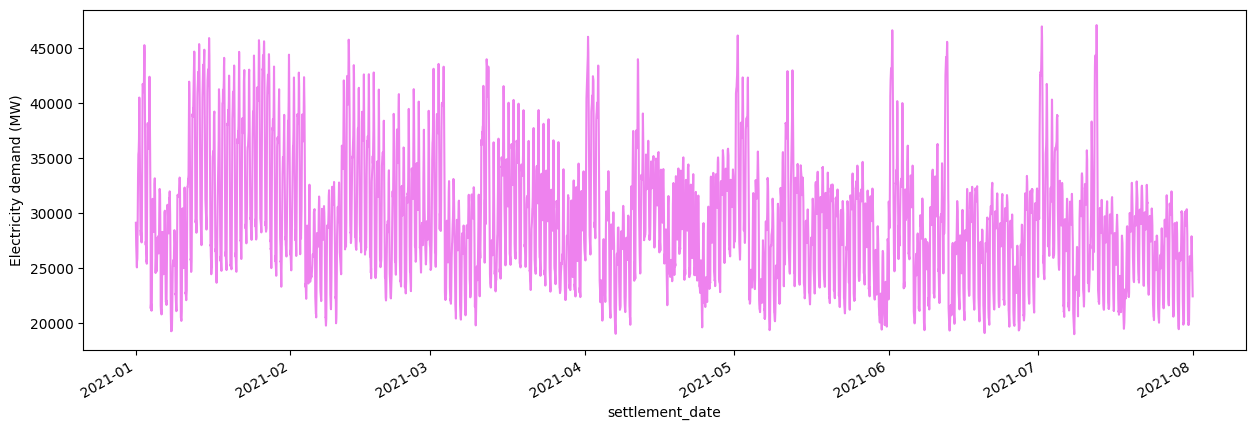

In [ ]:
df.loc[(df.index > "01-01-2021") & (df.index < "08-01-2021")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)", color='violet'
);

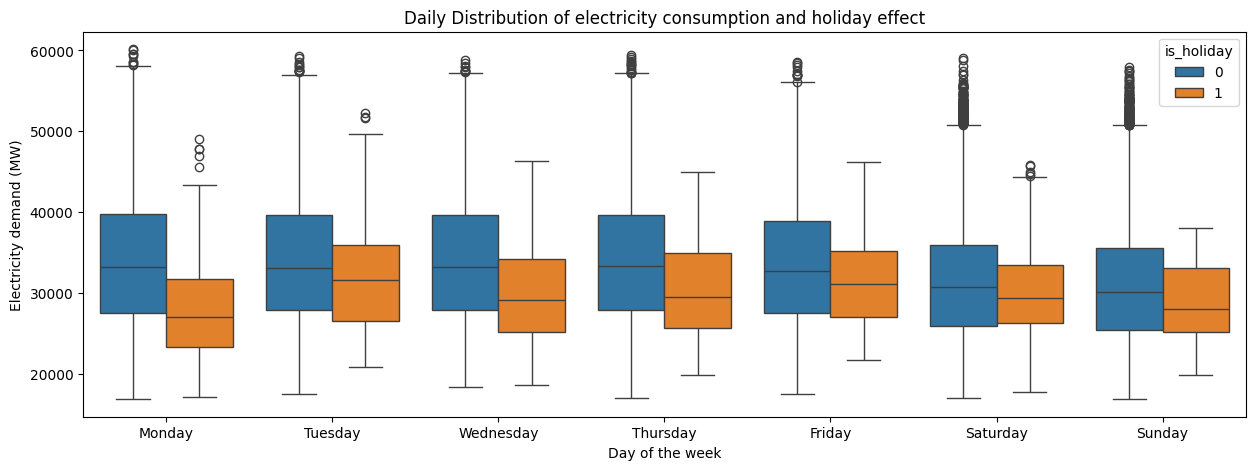

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

 layering the consumption data for two distinct years by ascertaining their comparative patterns.



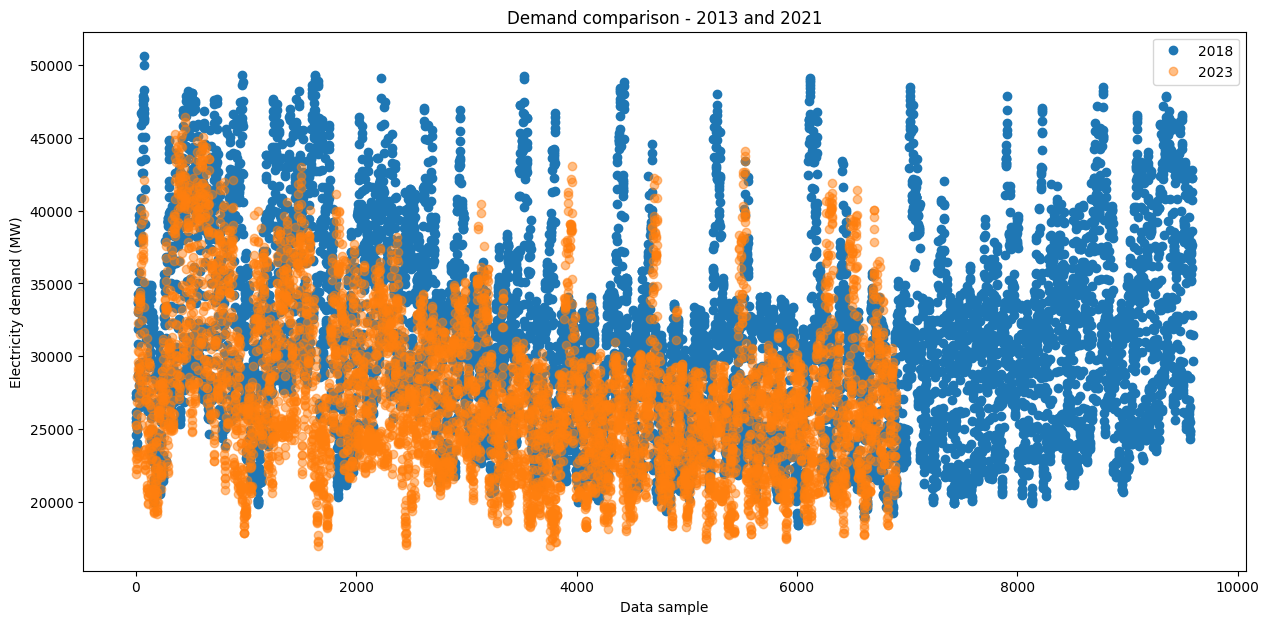

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2018") & (df.index < "12-01-2018")]["tsd"])),
    df.loc[(df.index > "01-01-2018") & (df.index < "12-01-2018")]["tsd"],
    "o",
    label="2018",
)


ax.plot(
    range(len(df.loc[(df.index > "01-01-2023") & (df.index < "12-01-2023")]["tsd"])),
    df.loc[(df.index > "01-01-2023") & (df.index < "12-01-2023")]["tsd"],
    "o",
    alpha=0.5,
    label="2023",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");


Calculate Mean Absolute Pertange Error given the true and
    predicted values

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

## SARIMA
###SARIMA data
The first step to create a SARIMA model is to modify the time series data. I will reduce the frequency of the data to daily summed samples. The reason to use the summed values instead of mean values is that we might see a spike at certain hours of the day that might be masked by the average, whereas summed valuers will show this.

<Axes: title={'center': 'Daily total electricity demand'}, xlabel='settlement_date', ylabel='Total electricity demand (MW)'>

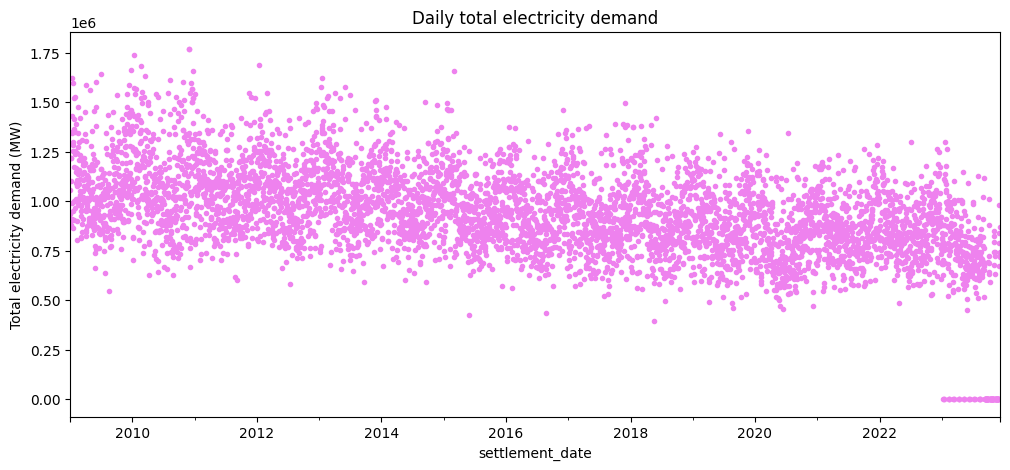

In [ ]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year

# Plotting with color set to violet
df_sarima["tsd"].plot(
    style=".",
    color="violet",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
)

In [ ]:
# Calculate the mean of non-zero values in the tsm column
mean_tsm = df.loc[df['tsd'] != 0, 'tsd'].mean()

# Replace 0 values with the mean
df.loc[df['tsd'] == 0, 'tsd'] = mean_tsm

In [ ]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]

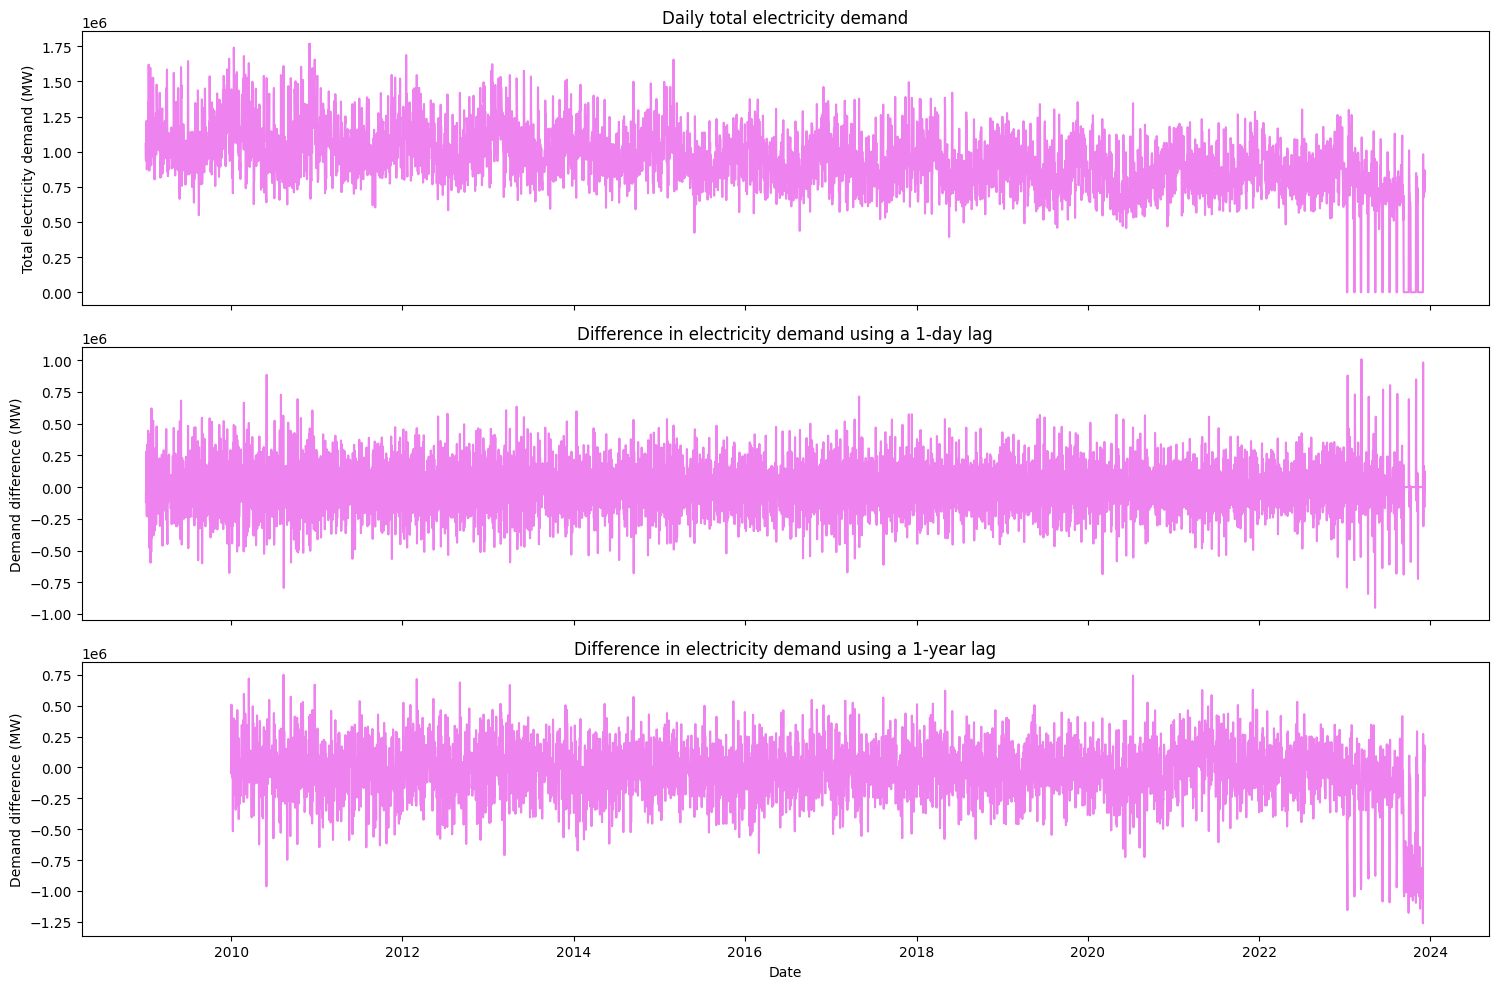

In [ ]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# Plotting the first subplot
axes[0].plot(df_sarima.index, df_sarima["tsd"], color='violet')
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")

# Plotting the second subplot
axes[1].plot(df_sarima.index, df_sarima["difference_day"], color='violet')
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")

# Plotting the third subplot
axes[2].plot(df_sarima.index, df_sarima["difference_year"], color='violet')
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag")

# Show the plots
plt.tight_layout()
plt.show()

There is no autocorrelation patterns given the number of samples in a 12-inch long plot, but this will be tackled in the next section.

###EDA SARIMA data and SARIMA parameter estimation
Performing ADFuller test, report the results and plot rolling statistics

In [ ]:
def dftest(timeseries, window_size):
    dftest = sm.stattools.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show()


In [ ]:
def autocorr_plots(data, lags=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot

    Args:
        - data: time series data
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

Ploting raw data, autocorreltion plot and partial autocorrelation plot
using two lags

In [ ]:
def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):

    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

checking the results from the ADF test:

Test Statistic            -1.009146
p-value                    0.749914
Lags Used                 30.000000
Observations Used       5424.000000
Critical Value (1%)       -3.431556
Critical Value (5%)       -2.862073
Critical Value (10%)      -2.567054
dtype: float64


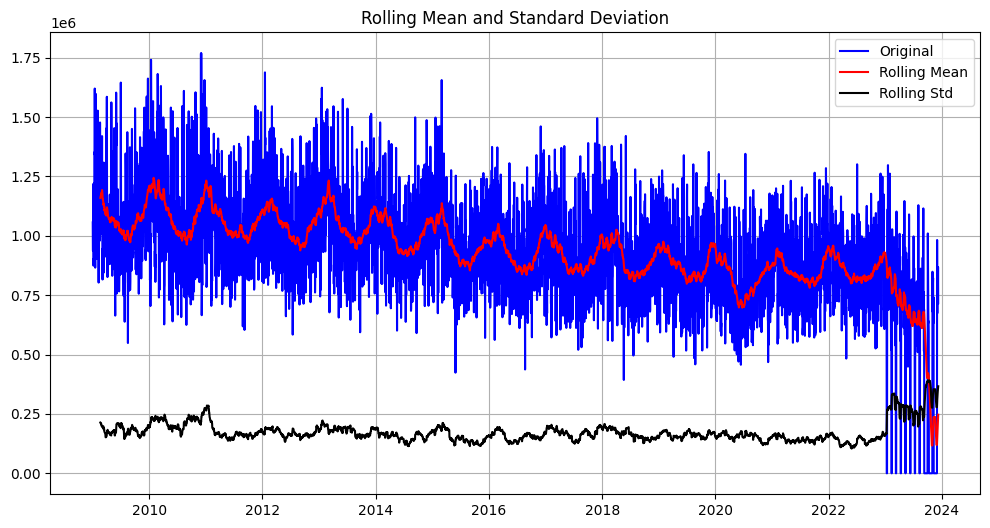

In [ ]:
dftest(df_sarima["tsd"], 50)

According to the test statistics and the p-value, the time series is stationary, but we can see that it doesn't meet the requirements of a stationary series

let look 1-day differenced data

Test Statistic           -35.354359
p-value                    0.000000
Lags Used                 29.000000
Observations Used       5424.000000
Critical Value (1%)       -3.431556
Critical Value (5%)       -2.862073
Critical Value (10%)      -2.567054
dtype: float64


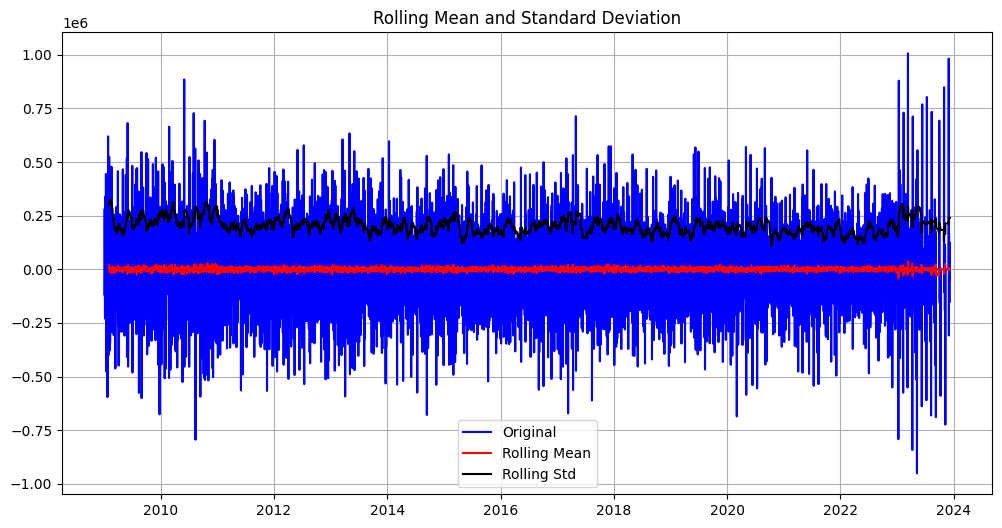

In [ ]:
dftest(df_sarima["difference_day"].dropna(), 30)

will use d-1 since the data is stational
decomposing the series

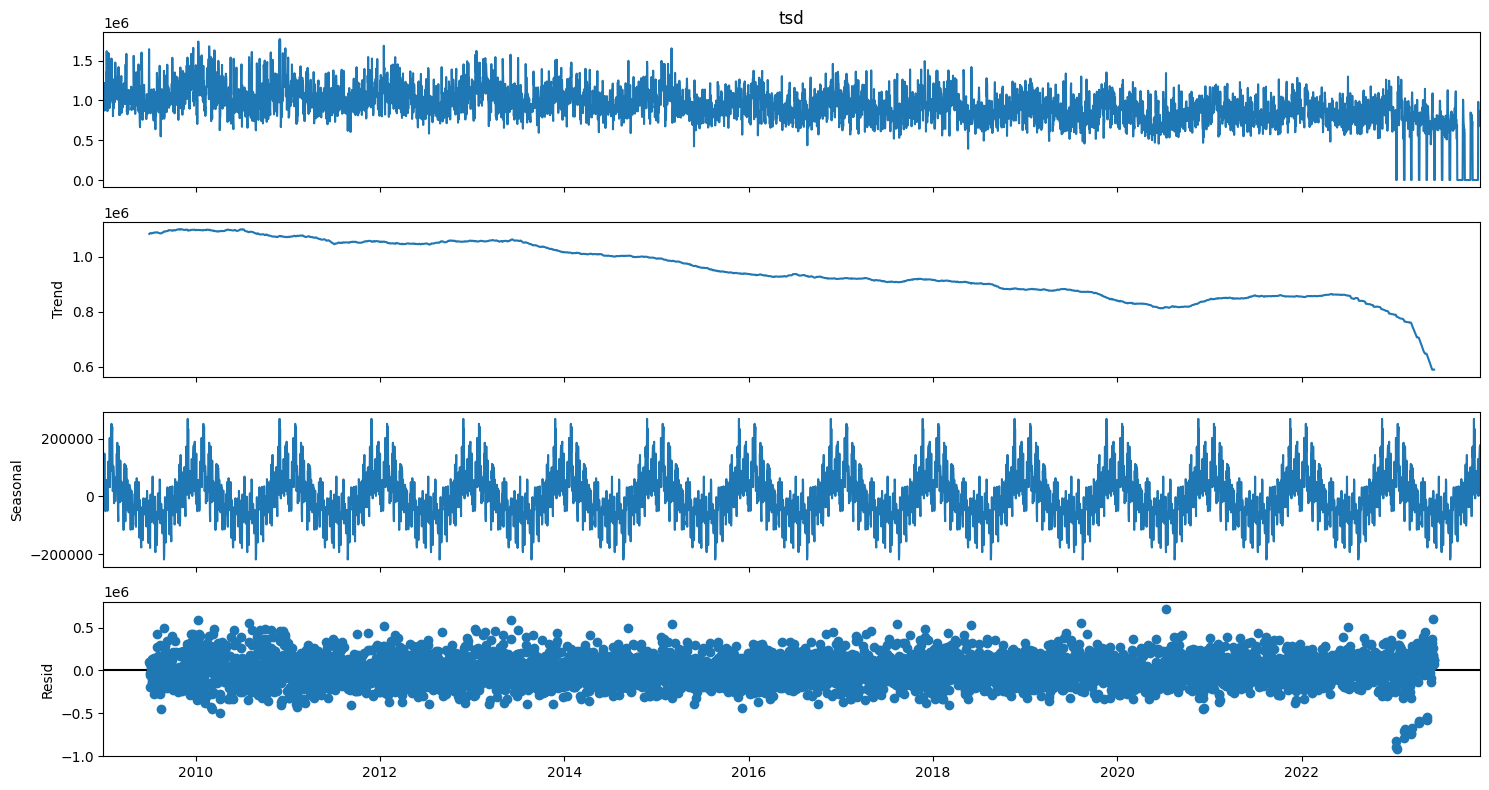

In [ ]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((15, 8))
fig.tight_layout()

checking stationarity

Test Statistic            -4.102406
p-value                    0.000960
Lags Used                 32.000000
Observations Used       5422.000000
Critical Value (1%)       -3.431557
Critical Value (5%)       -2.862073
Critical Value (10%)      -2.567054
dtype: float64


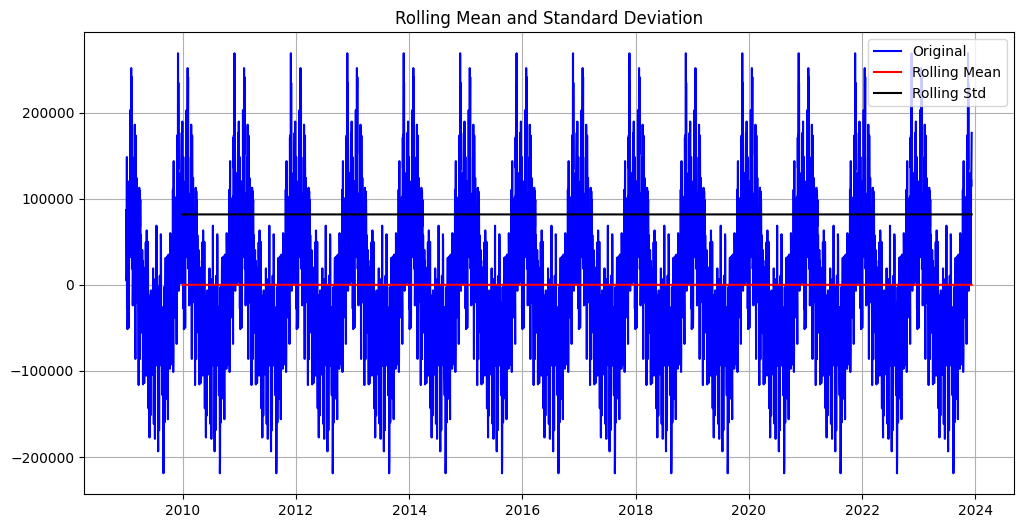

In [ ]:
dftest(decompose.seasonal, 364)

1-year lag data

Test Statistic            -2.763426
p-value                    0.063691
Lags Used                 30.000000
Observations Used       5060.000000
Critical Value (1%)       -3.431643
Critical Value (5%)       -2.862111
Critical Value (10%)      -2.567074
dtype: float64


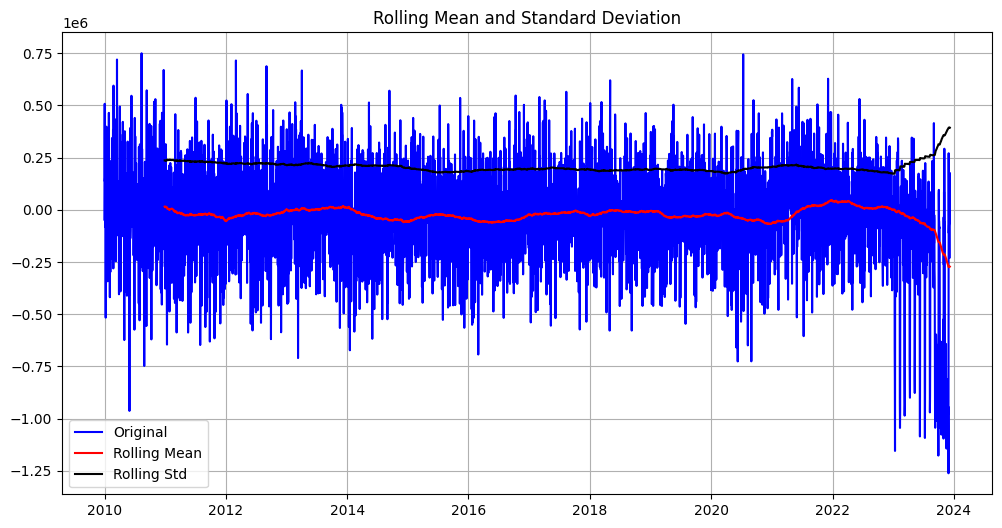

In [ ]:
dftest(df_sarima["difference_year"].dropna(), 364)

Since the 1-year differenced data is stationary, D=1.

To determine p and q, one can analyse the autocorrelation plots of the original data:


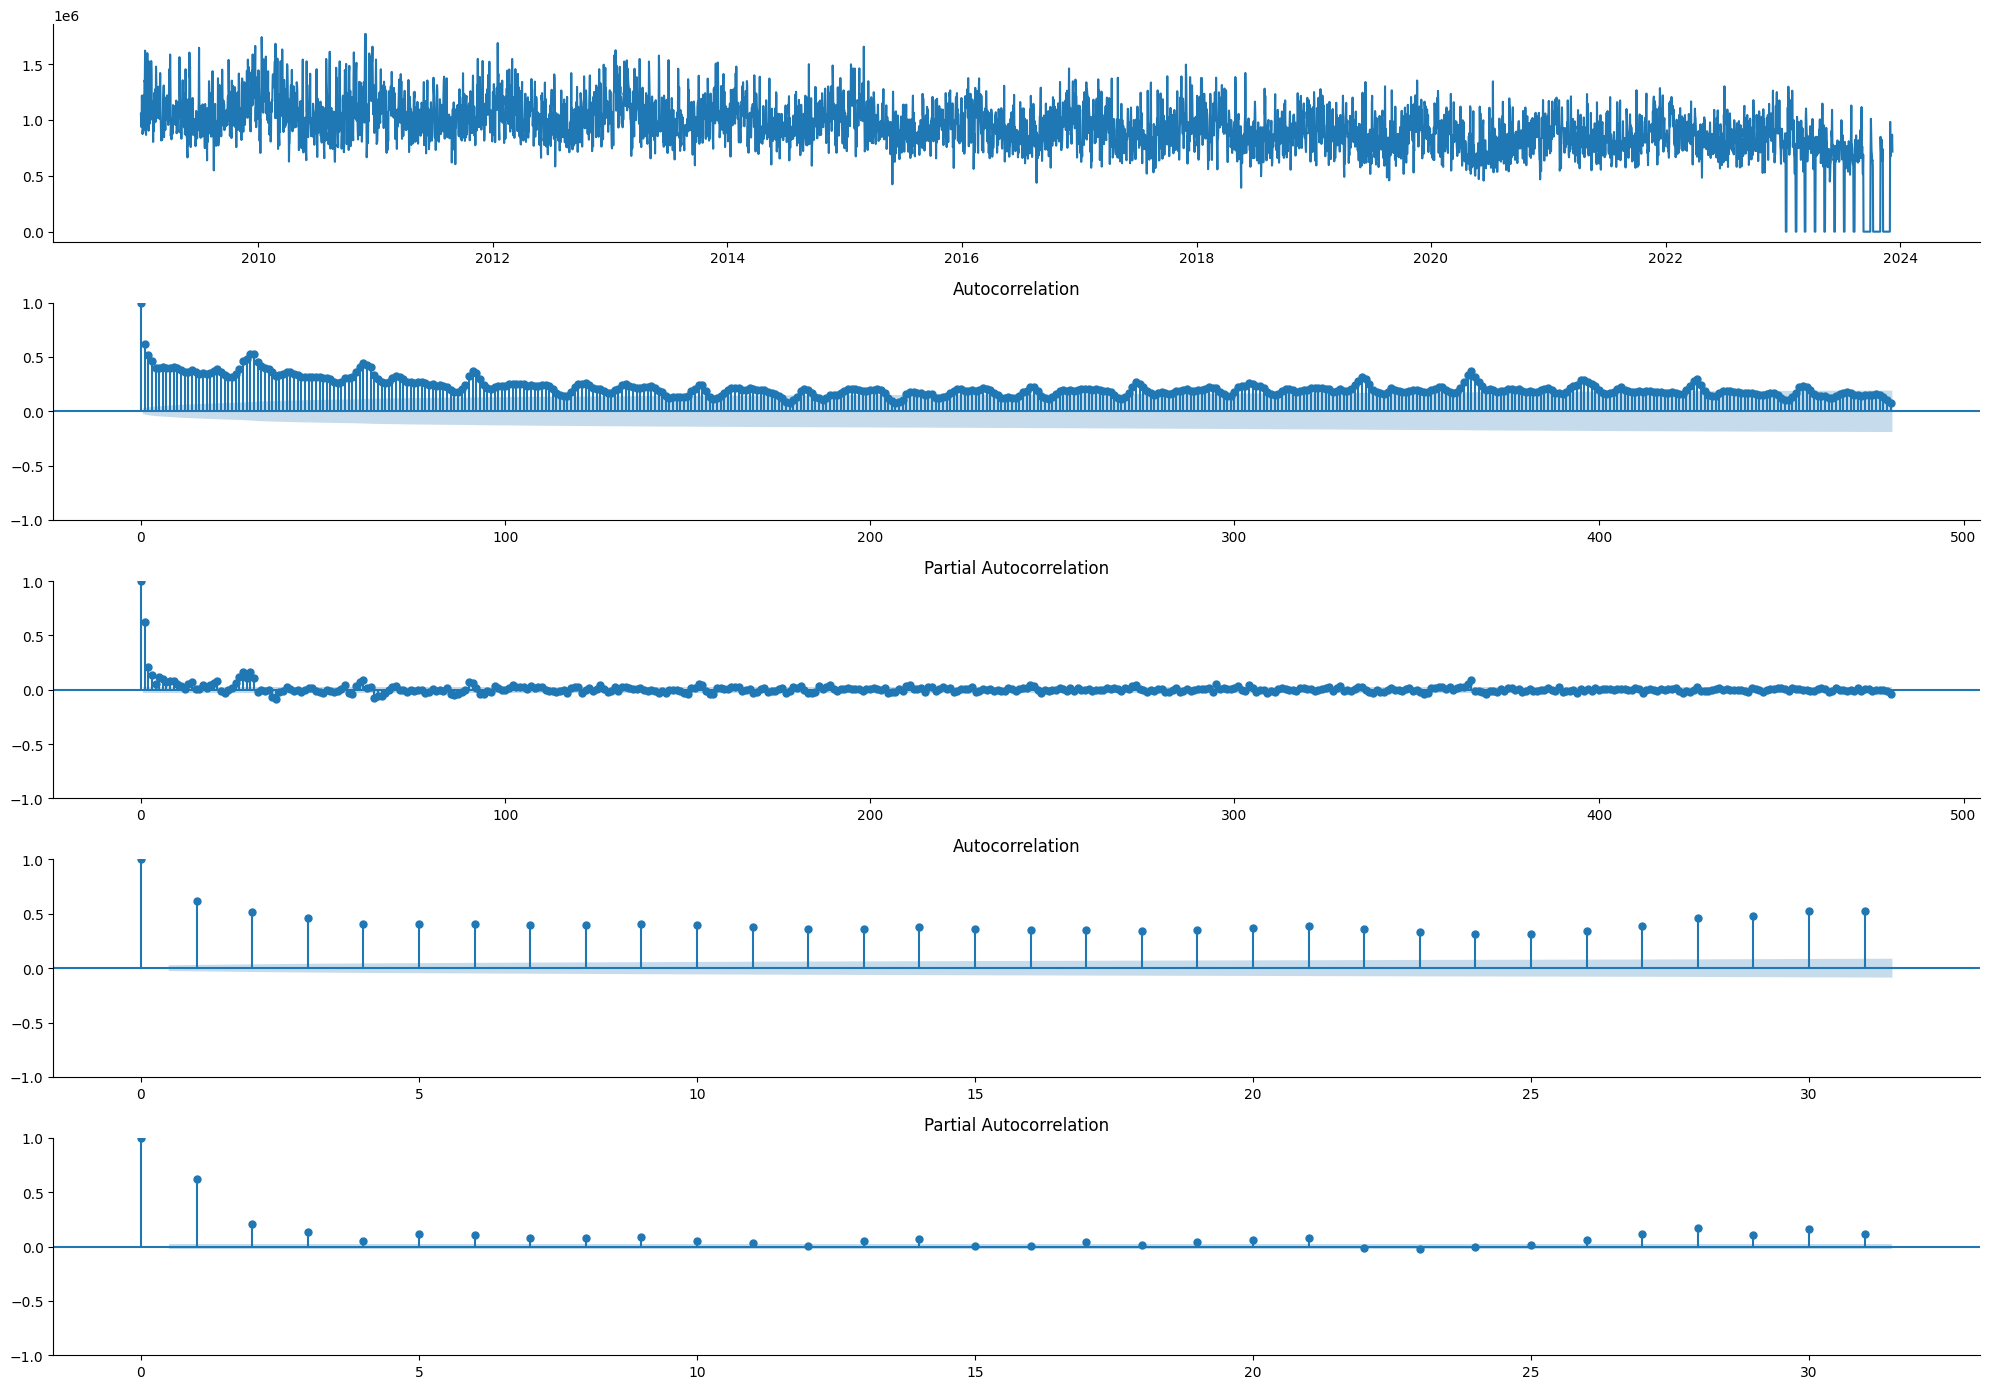

In [ ]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)

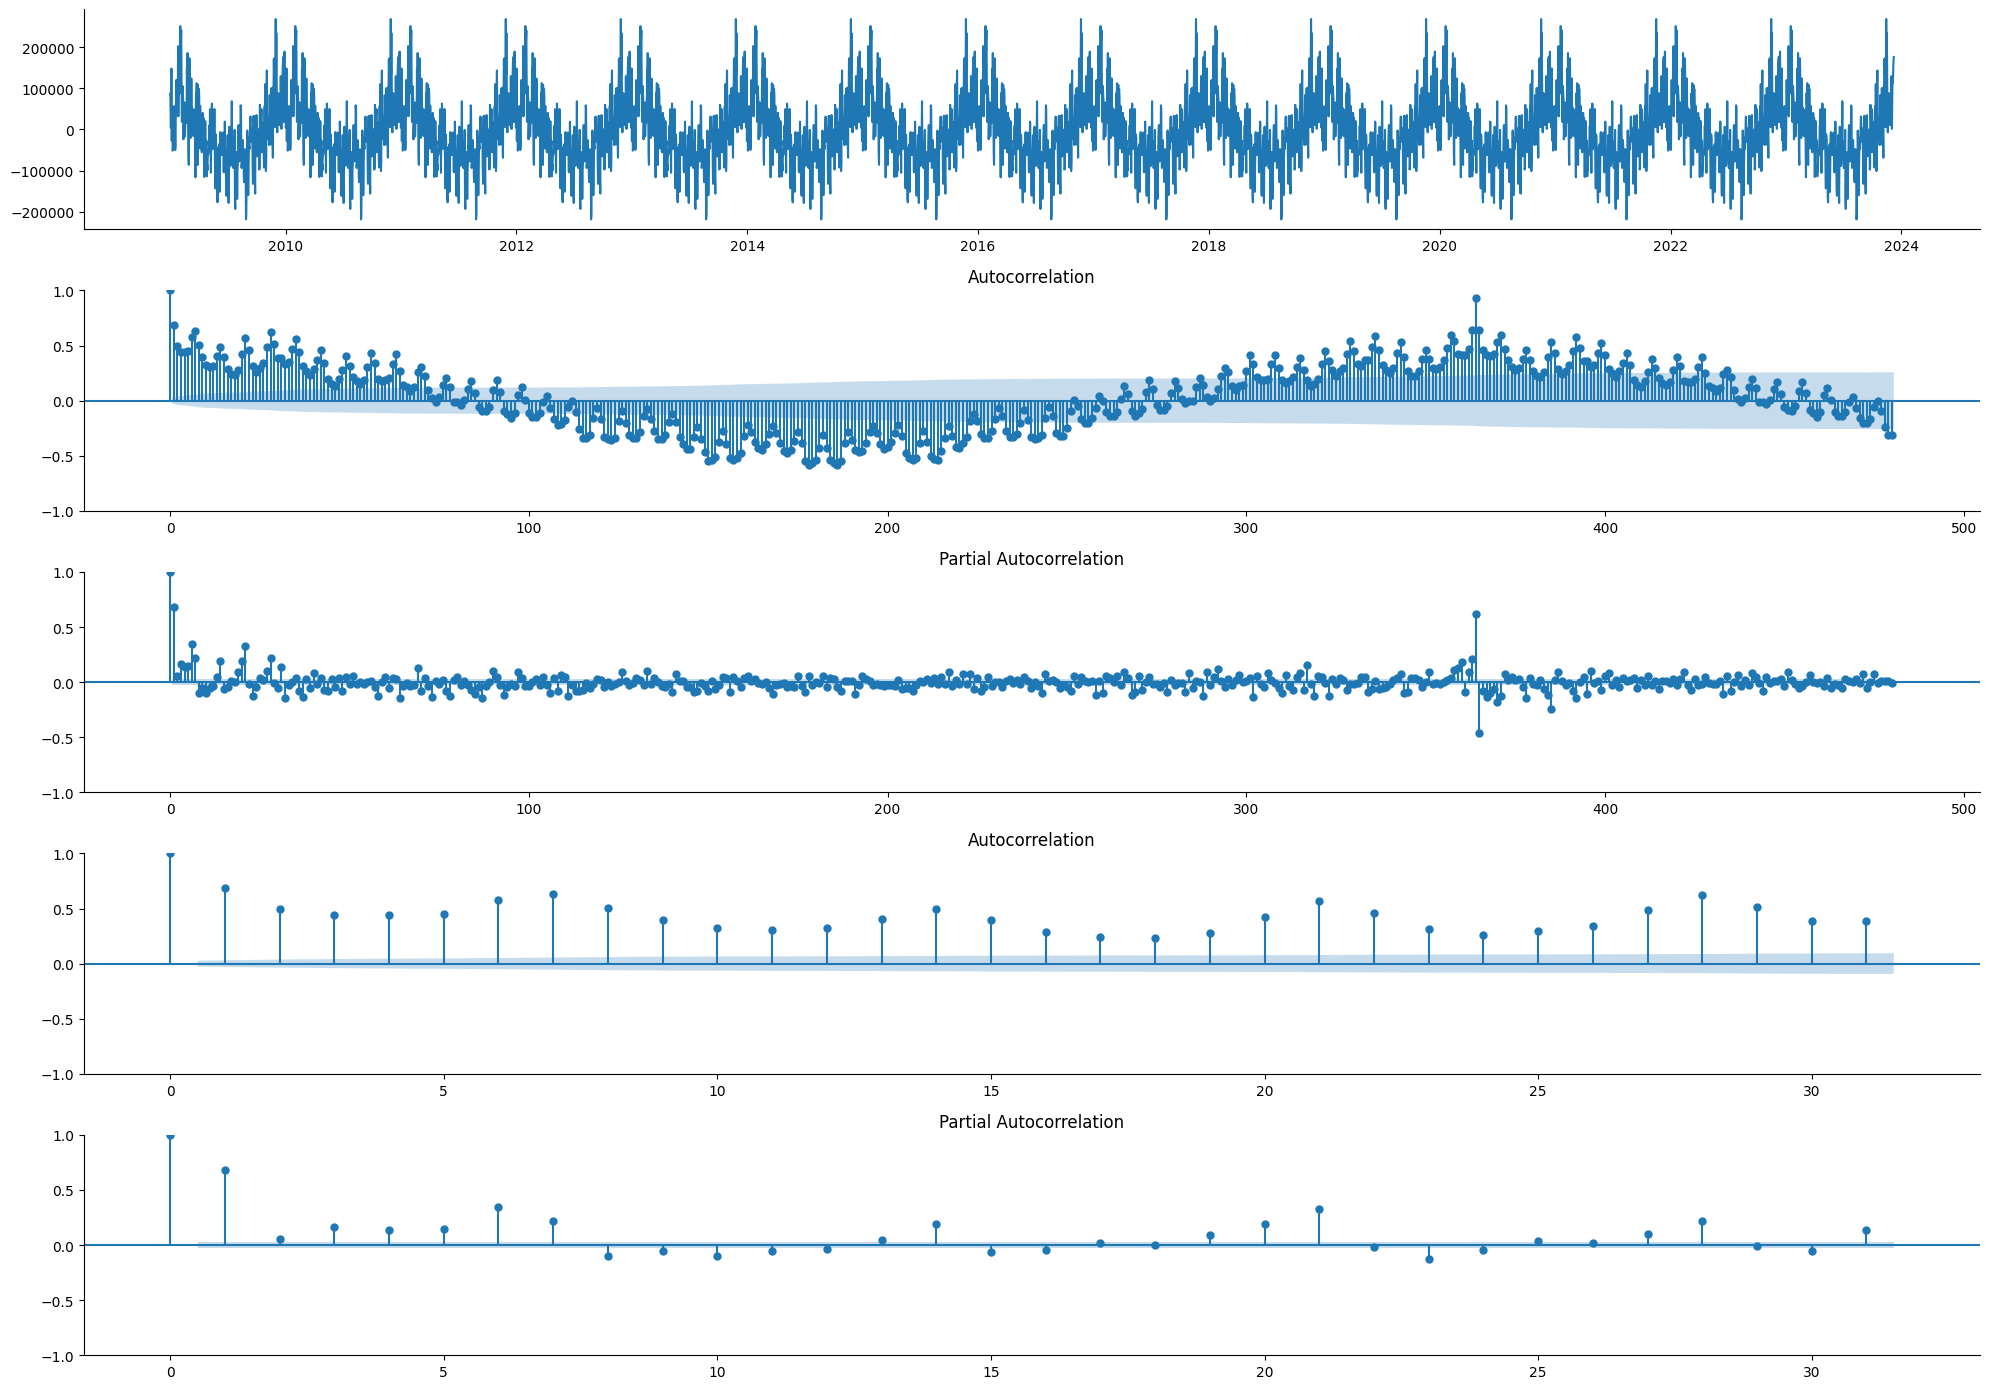

In [ ]:
autocorr_plots_dual_lags(decompose.seasonal, lags_1=480, lags_2=31)

ual_lags(decompose.seasonal, lags_1=480, lags_2=31)

These graphs show the same issues since the values either take many lags to fall within the confidence interval or they never do it continuously. A good first estimation is P=3, Q=2 and M=12.

I know that Q should be higher, but as we will see, as I increase the values of the parameters it takes way longer to train the model as there are more parameters to compute. At first, I want a reasonable estimation that doesn't take very long to run.

##Train-test split

In [ ]:
threshold_date = "01-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

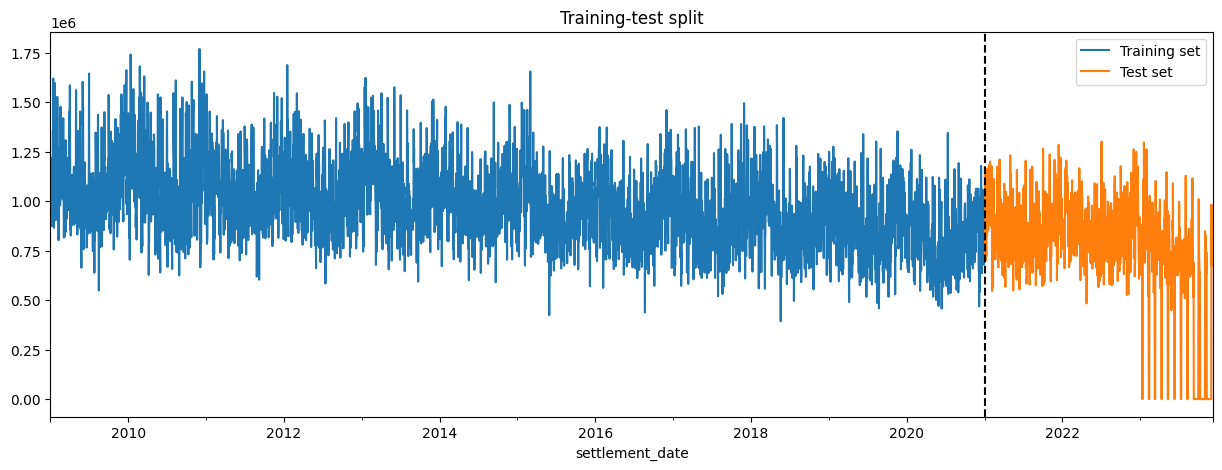

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

##Model 1
creating a model with p, q, P and Q values equal to 1 and compute the error.

statistical tests

In [ ]:
def stats_test(sar_model):

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = statsmodels.stats.stattools.durbin_watson(
        sar_model.filter_results.standardized_forecasts_error[
            0, sar_model.loglikelihood_burn :
        ]
    )

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("Durbin-Watson: d={:.2f}".format(durbin_watson))

creating thre model
Perform statisticals tests to check if the model parameters are right

        - Plot model diagnostics
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval

In [ ]:
def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):


    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 8),
    )

    # Predict on test data
    predict = sarima_model.get_prediction(
        start="01-01-2021", end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    return execution_time, mape, sarima_model


Normality: val=97.193, p=0.000
Ljung-Box: val=605.108, p=0.000
Heteroskedasticity: val=0.755, p=0.000
Durbin-Watson: d=1.47
-------------------------------------------------------------
Model 1 Performance Metrics:
Execution Time: 0:00:21.318835
Mean Absolute Percentage Error: 16.66%
-------------------------------------------------------------


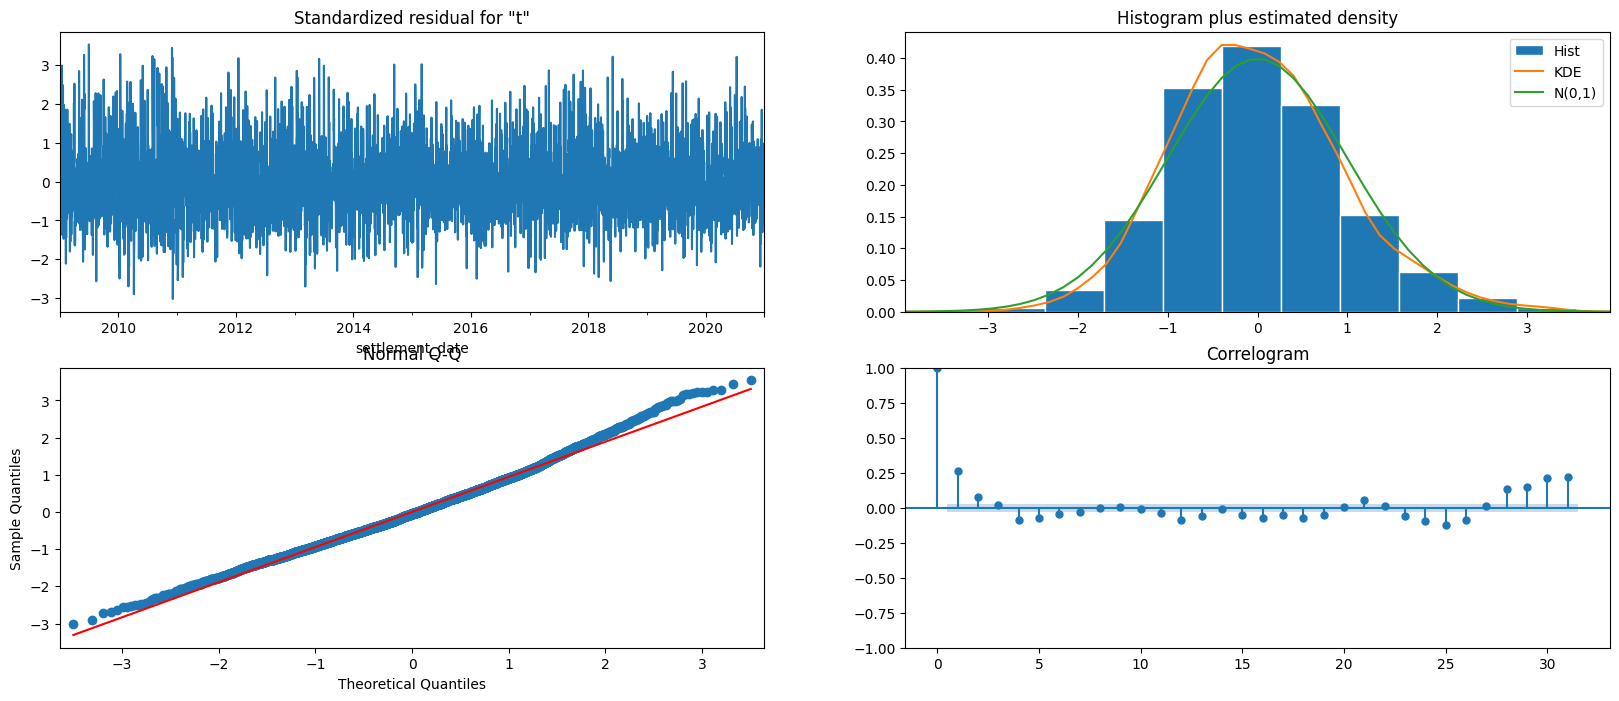

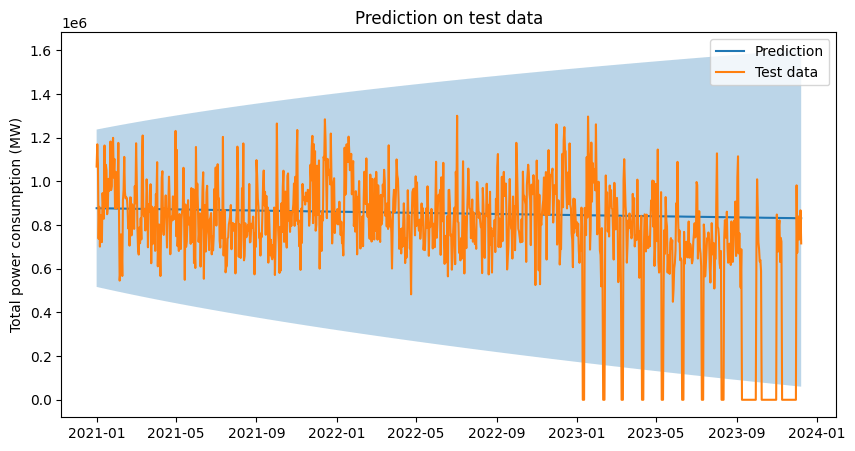

In [ ]:
def print_performance_metrics(sarima_model1, execution_time1, mape1):
    print(f"Model {sarima_model1} Performance Metrics:")
    print(f"Execution Time: {execution_time1}")

    if mape1 is not None and mape1 != float('inf'):
        print(f"Mean Absolute Percentage Error: {mape1:.2f}%")
    else:
        print("Mean Absolute Percentage Error: Not computable or infinite")

    print("-------------------------------------------------------------")

# Assuming you've fixed create_predict_analyse to return reasonable values for mape
[execution_time1, mape1, sarima_model1] = create_predict_analyse(
    train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
)

print_performance_metrics(1, execution_time1, mape1)


In [ ]:
# Define the start and end dates for prediction
start_date = '2024-01-01'
end_date = '2024-12-31'

# Define other features for prediction
new_features = {
    "day_of_month": 1,  # Example: 1st day of the month
    "day_of_week": 2,   # Example: Tuesday
    "day_of_year": 365, # Example: Last day of the year
    "quarter": 1,       # Example: First quarter
    "month": 3,         # Example: March
    "year": 2024,       # Example: Year 2024
    "week_of_year": 10  # Example: 10th week of the year
}

# Convert features to DataFrame
features_df = pd.DataFrame(new_features, index=[0])

# Make predictions with the SARIMA model using the provided features
try:
    # Assuming 'sarima_model1' is the loaded SARIMA model
    predictions = sarima_model1.predict(start=start_date, end=end_date, exog=features_df)

    # Check if predictions are not None
    if predictions is not None:
        # Print or visualize the predicted values
        print("Predictions:", predictions)

        # Check specific values if needed
        for pred in predictions:
            if pred is None:
                print("Warning: Some predictions are None.")
                break
    else:
        print("Error: Predictions are None.")
except Exception as e:
    print("Error occurred during prediction:", str(e))


Predictions: 2024-01-01    830526.679069
2024-01-02    830340.243656
2024-01-03    830257.118886
2024-01-04    830332.023928
2024-01-05    830170.536505
                  ...      
2024-12-27    815454.635155
2024-12-28    815372.498100
2024-12-29    815447.283746
2024-12-30    815287.332979
2024-12-31    815280.329839
Freq: D, Name: predicted_mean, Length: 366, dtype: float64


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming y_true and y_pred are your true and predicted values respectively
y_true = np.array([10, 20, 30, 40, 50])
y_pred = np.array([12, 18, 32, 38, 48])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 2.0
Root Mean Squared Error (RMSE): 2.0


In [ ]:
import pickle

# Assuming sarima_model_2 is the SARIMA model object you want to save
# Replace 'sarima_model_2' with the actual name of your SARIMA model object

# Define the file path where you want to save the model
file_path = 'sarima_model1.pkl'

# Save the model to a file
with open(file_path, 'wb') as f:
    pickle.dump(sarima_model1, f)

print("SARIMA model saved successfully as 'sarima_model.pkl'")


SARIMA model saved successfully as 'sarima_model.pkl'
